In [1]:
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_parquet("../datasets/for_hire_january_2021.parquet")

In [4]:
print(f"There are {data.shape[0]} records for \"For Hire Vehicle Trip Records\"")

There are 1154112 records for "For Hire Vehicle Trip Records"


#### Computing duration

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [7]:
data['duration'] = data.dropOff_datetime - data.pickup_datetime
# convert duration to minutes
data['duration'] = data['duration'].apply(
    lambda sample: sample.total_seconds() / 60
)
print(f"Average trip duration in January is: {data['duration'].mean()}")

Average trip duration in January is: 19.167224093791006


#### Data preparation

/Users/marvinmboya/miniforge3/envs/pytorch_base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


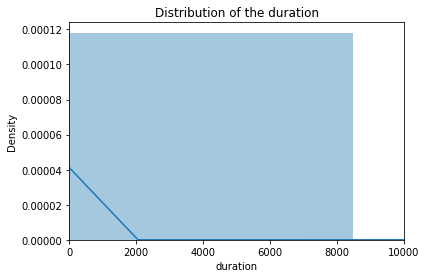

Dropped records: 44286


In [16]:
sns.distplot(data['duration'])
plt.title("Distribution of the duration")
plt.xlim([0, 10_000])
plt.show()

dropped_records = data.loc[~(
    (data['duration'] >= 1) & (data['duration'] <= 60)
    )].shape[0]

new_data = data.loc[(
    (data['duration'] >= 1) & (data['duration'] <= 60)
    )]

print(f"Dropped records: {dropped_records}")

#### Missing values

In [18]:
train_feature_columns = ['PUlocationID', 'DOlocationID']
train_target_column = ["duration"]

In [32]:
new_data[train_feature_columns] = new_data[
    train_feature_columns
].fillna(-1)

/var/folders/32/5jtr8wqx79177fbb401wgk3w0000gn/T/ipykernel_6468/303388241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[train_feature_columns] = new_data[train_feature_columns].fillna(-1)


In [45]:
print("Fraction of missing values in Pickup Location ID:",
     f"{((new_data[train_feature_columns[0]] == -1).sum()/new_data[train_feature_columns[0]].shape[0]) * 100:.2f}%")

Fraction of missing values in Pickup Location ID: 83.53%


#### One-hot encoding

In [46]:
new_data[train_feature_columns] = new_data[train_feature_columns].astype(str)

/var/folders/32/5jtr8wqx79177fbb401wgk3w0000gn/T/ipykernel_6468/1591722371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[train_feature_columns] = new_data[train_feature_columns].astype(str)


In [47]:
# Turn the columns into dictionaries
train_dict = new_data[train_feature_columns].to_dict(orient='records')

In [48]:
dict_vectorizer = DictVectorizer()
train_features = dict_vectorizer.fit_transform(train_dict)

In [50]:
print(f"Matrix dimensionality: {train_features.shape[1]}")

Matrix dimensionality: 525


#### Model training

In [52]:
train_targets = new_data[train_target_column].values

In [54]:
linear_regression = LinearRegression()

In [55]:
linear_regression.fit(train_features, train_targets)

LinearRegression()

In [56]:
train_predictions = linear_regression.predict(train_features)

In [57]:
rmse = mean_squared_error(train_targets, train_predictions, squared=False)
print(f"RMSE on train: {rmse:.2f}")

RMSE on train: 10.53


### Testing data

In [60]:
def read_dataframe(file_name):
    data = pd.read_parquet(file_name)
    data['duration'] = data.dropOff_datetime - data.pickup_datetime
    # convert duration to minutes
    data['duration'] = data['duration'].apply(
        lambda sample: sample.total_seconds() / 60
    )
    data = data.loc[(data['duration'] >= 1) & (data['duration'] <= 60)]
    categorical = ['PUlocationID', 'DOlocationID']
    data[categorical] = data[categorical].astype(str)
    return data    

In [61]:
validation_data = read_dataframe("../datasets/for_hire_february_2021.parquet")

In [62]:
validation_data.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,nan,225.0,None,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,nan,61.0,None,B00037,8.966667


In [63]:
val_feature_columns = ['PUlocationID', 'DOlocationID']
val_target_column = "duration"

validation_dict = validation_data[val_feature_columns].to_dict(orient='records')
val_features = dict_vectorizer.transform(validation_dict)

In [65]:
val_targets = validation_data[val_target_column].values

val_predictions = linear_regression.predict(val_features)

rmse = mean_squared_error(val_targets, val_predictions, squared=False)
print(f"RMSE on validation: {rmse:.2f}")

RMSE on validation: 11.36
